# About Dataset

## Context

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

## Data Description

### Train Data


- id: Unique ID for the customer
- Gender: Gender of the customer
- Age:	Age of the customer
- Driving_License: 0  Customer does not have DL, 1  Customer already has DL
- Region_Code: Unique code for the region of the customer
- Previously_Insured: 1 Customer already has Vehicle Insurance, 0 Customer doesn't have Vehicle Insurance
- Vehicle_Age: Age of the Vehicle
- Vehicle_Damage: 1 Customer got his/her vehicle damaged in the past. 0 Customer didn't get his/her vehicle damaged in the past.
- Annual_Premium: The amount customer needs to pay as premium in the year
- Policy_Sales_Channel: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
- Vintage: Number of Days, Customer has been associated with the company
- Response: 1 Customer is interested, 0 Customer is not interested

# 0.0 Imports

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import psycopg2 as pg
import sqlalchemy as db
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import scikitplot as skplt

from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from fast_ml.model_development import train_valid_test_split
from fast_ml import eda
from scipy import stats
from category_encoders import TargetEncoder


from IPython.display import display, HTML

 ## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML("<style>.container { width:97% !important; }</style>"))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set
    
    
    
    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [3]:
jupyter_settings()

## 0.2 Loading Data

In [3]:
#credentials

host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd = 'cdspa'

In [4]:
#create string connection and postgre engine

string_connect = 'postgresql://' + username + ':' + pwd + '@' + host + ':' + str(port) + '/' + database
engine = db.create_engine(string_connect)
conn1 = engine.connect()


In [5]:
# make query

query_tables = """

SELECT * 
FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
				   LEFT JOIN pa004.insurance i ON (u.id = i.id)



"""

In [121]:
# Read dataFrame

df_raw = pd.read_sql(query_tables, conn1)
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 0.3 Split data frame in Train, Validation and Test

In [223]:
X = df_raw.drop(['response'], axis=1)
y = df_raw['response'].copy()

In [224]:
#Split train-test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [225]:
# Split Train_validation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

df = pd.concat( [X_train, y_train], axis=1)

# 1.0 Descrição dos Dados

In [226]:
df1 = df.copy()

## 1.1 Rename Columns

In [11]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 1.2 Data Dimension

In [12]:
df1.shape

(243909, 12)

## 1.3 Data Types

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243909 entries, 217927 to 169494
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    243909 non-null  int64  
 1   gender                243909 non-null  object 
 2   age                   243909 non-null  int64  
 3   region_code           243909 non-null  float64
 4   policy_sales_channel  243909 non-null  float64
 5   driving_license       243909 non-null  int64  
 6   vehicle_age           243909 non-null  object 
 7   vehicle_damage        243909 non-null  object 
 8   previously_insured    243909 non-null  int64  
 9   annual_premium        243909 non-null  float64
 10  vintage               243909 non-null  int64  
 11  response              243909 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 24.2+ MB


## 1.4 Check NA

In [14]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5 Change Types

In [15]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

In [130]:
df1['region_code'] = df1['region_code'].astype(int)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

## 1.6 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes( include = ['int32', 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int32', 'int64', 'float'] )

### 1.6.1 Numerical Attributes

In [18]:
# Central tendency metrics

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersionl metrics - std, min, max, range, kurtosis, skew

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat( [ d2, d3, ct1, ct2, d1, d4, d5, d6 ]).T.reset_index()

m.columns = ( [ 'features', 'min', 'max', 'mean', 'median', 'std', 'range', 'skew', 'kurtosis'])

m

,features,min,max,mean,median,std,range,skew,kurtosis
0,id,1.0,381109.0,190629.391027,190463.0,110113.314639,381108.0,0.000958,-1.202639
1,age,20.0,85.0,38.840338,36.0,15.504093,65.0,0.670266,-0.567091
2,region_code,0.0,52.0,26.395664,28.0,13.225380,52.0,-0.116015,-0.864970
3,policy_sales_channel,1.0,163.0,111.872969,125.0,54.265997,162.0,-0.893386,-0.983596
4,driving_license,0.0,1.0,0.997827,1.0,0.046564,1.0,-21.382550,455.217194
5,previously_insured,0.0,1.0,0.458667,0.0,0.498289,1.0,0.165901,-1.972493
6,annual_premium,2630.0,540165.0,30608.226572,31699.0,17212.946509,537535.0,1.719756,32.837156
7,vintage,10.0,299.0,154.297090,154.0,83.710513,289.0,0.002952,-1.201692
8,response,0.0,1.0,0.122697,0.0,0.328090,1.0,2.300012,3.290082


### 1.7.1 Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [20]:
df1[['gender', 'response']].groupby('response').value_counts().reset_index()

,response,gender,count
0,0,Male,113916
1,0,Female,100066
2,1,Male,18260
3,1,Female,11667


In [21]:
df1[['vehicle_age', 'response']].groupby('response').value_counts().reset_index()

,response,vehicle_age,count
0,0,1-2 Year,106133
1,0,< 1 Year,100586
2,0,> 2 Years,7263
3,1,1-2 Year,22354
4,1,< 1 Year,4589
5,1,> 2 Years,2984


In [22]:
df1[['vehicle_damage', 'response']].groupby('response').value_counts().reset_index()

,response,vehicle_damage,count
0,0,No,119990
1,0,Yes,93992
2,1,Yes,29300
3,1,No,627


# 2.0 Featuring Engineering

In [227]:
df2 = df1.copy()

## 2.1 Criação das Hipóteses

### 2.1.1 Hipóteses Cliente

**1-** CLientes com mais idade deveriam ter mais propensão a comprar o seguro

**2-** CLientes sem habilitação deveriam ter mais propensão a comprar o seguro

**3-** CLientes que ganham maior remuneração deveriam ter mais propensão a comprar

**4-** Pessoas que são clientes a mais tempo deveriam ter mais propensão a comprar

**5-** Clientes do gênero femnino deveriam ter mais propensão a comprar

**6-** Clientes com prêmio de seguro anual menor deveriam ter mais propensão a comprar

**7-** Clientes que já tem seguro deveriam ter menos propensão a comprar



### 2.1.2 Hipóteses do Veículo

**1-** Clientes com veículos mais novos deveriam ter mais propensão a comprar

**2-** Clientes com veículos que já sofreram acidentes deveriam ter mais propensão a comprar

## 2.2 Lista Final das Hipóteses

**1-** CLientes com mais idade deveriam ter mais propensão a comprar o seguro

**2-** CLientes sem habilitação deveriam ter mais propensão a comprar o seguro

**3-** CLientes que ganham maior remuneração deveriam ter mais propensão a comprar

**4-** Pessoas que são clientes a mais tempo deveriam ter mais propensão a comprar

**5-** Clientes do gênero femnino deveriam ter mais propensão a comprar

**6-** Clientes com prêmio de seguro anual menor deveriam ter mais propensão a comprar

**7-** Clientes que já tem seguro deveriam ter menos propensão a comprar

**8-** Clientes com veículos mais novos deveriam ter mais propensão a comprar

**9-** Clientes com veículos que já sofreram acidentes deveriam ter mais propensão a comprar

## 2.3 Feature Engineering

In [228]:

df2['time_of_customer'] = df['vintage'].apply(lambda x: 'new' if x < 50 else 'moderate' if x < 100 else 'medium' if x < 150 else 'professional' if x < 200 else 'expert' if x < 250 else 'old')


# 3.0 Exploratory Data Analysis

In [229]:
df3 = df2.copy()

## 3.1 Análise Univariada

### 3.1.1 Response Variable

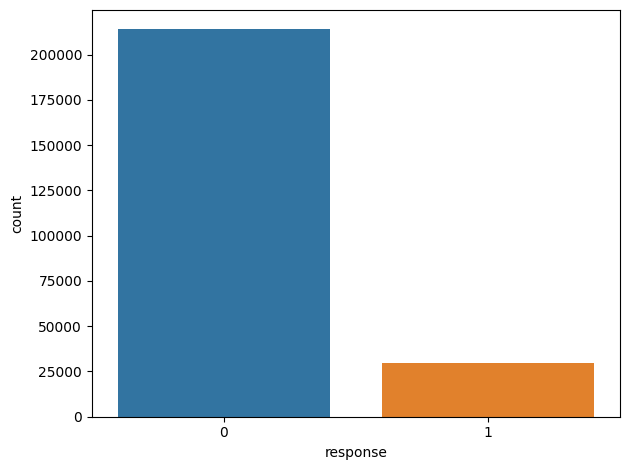

In [26]:
sns.countplot(data = df3, x='response')
plt.tight_layout();

### 3.1.2 Numerical Variable

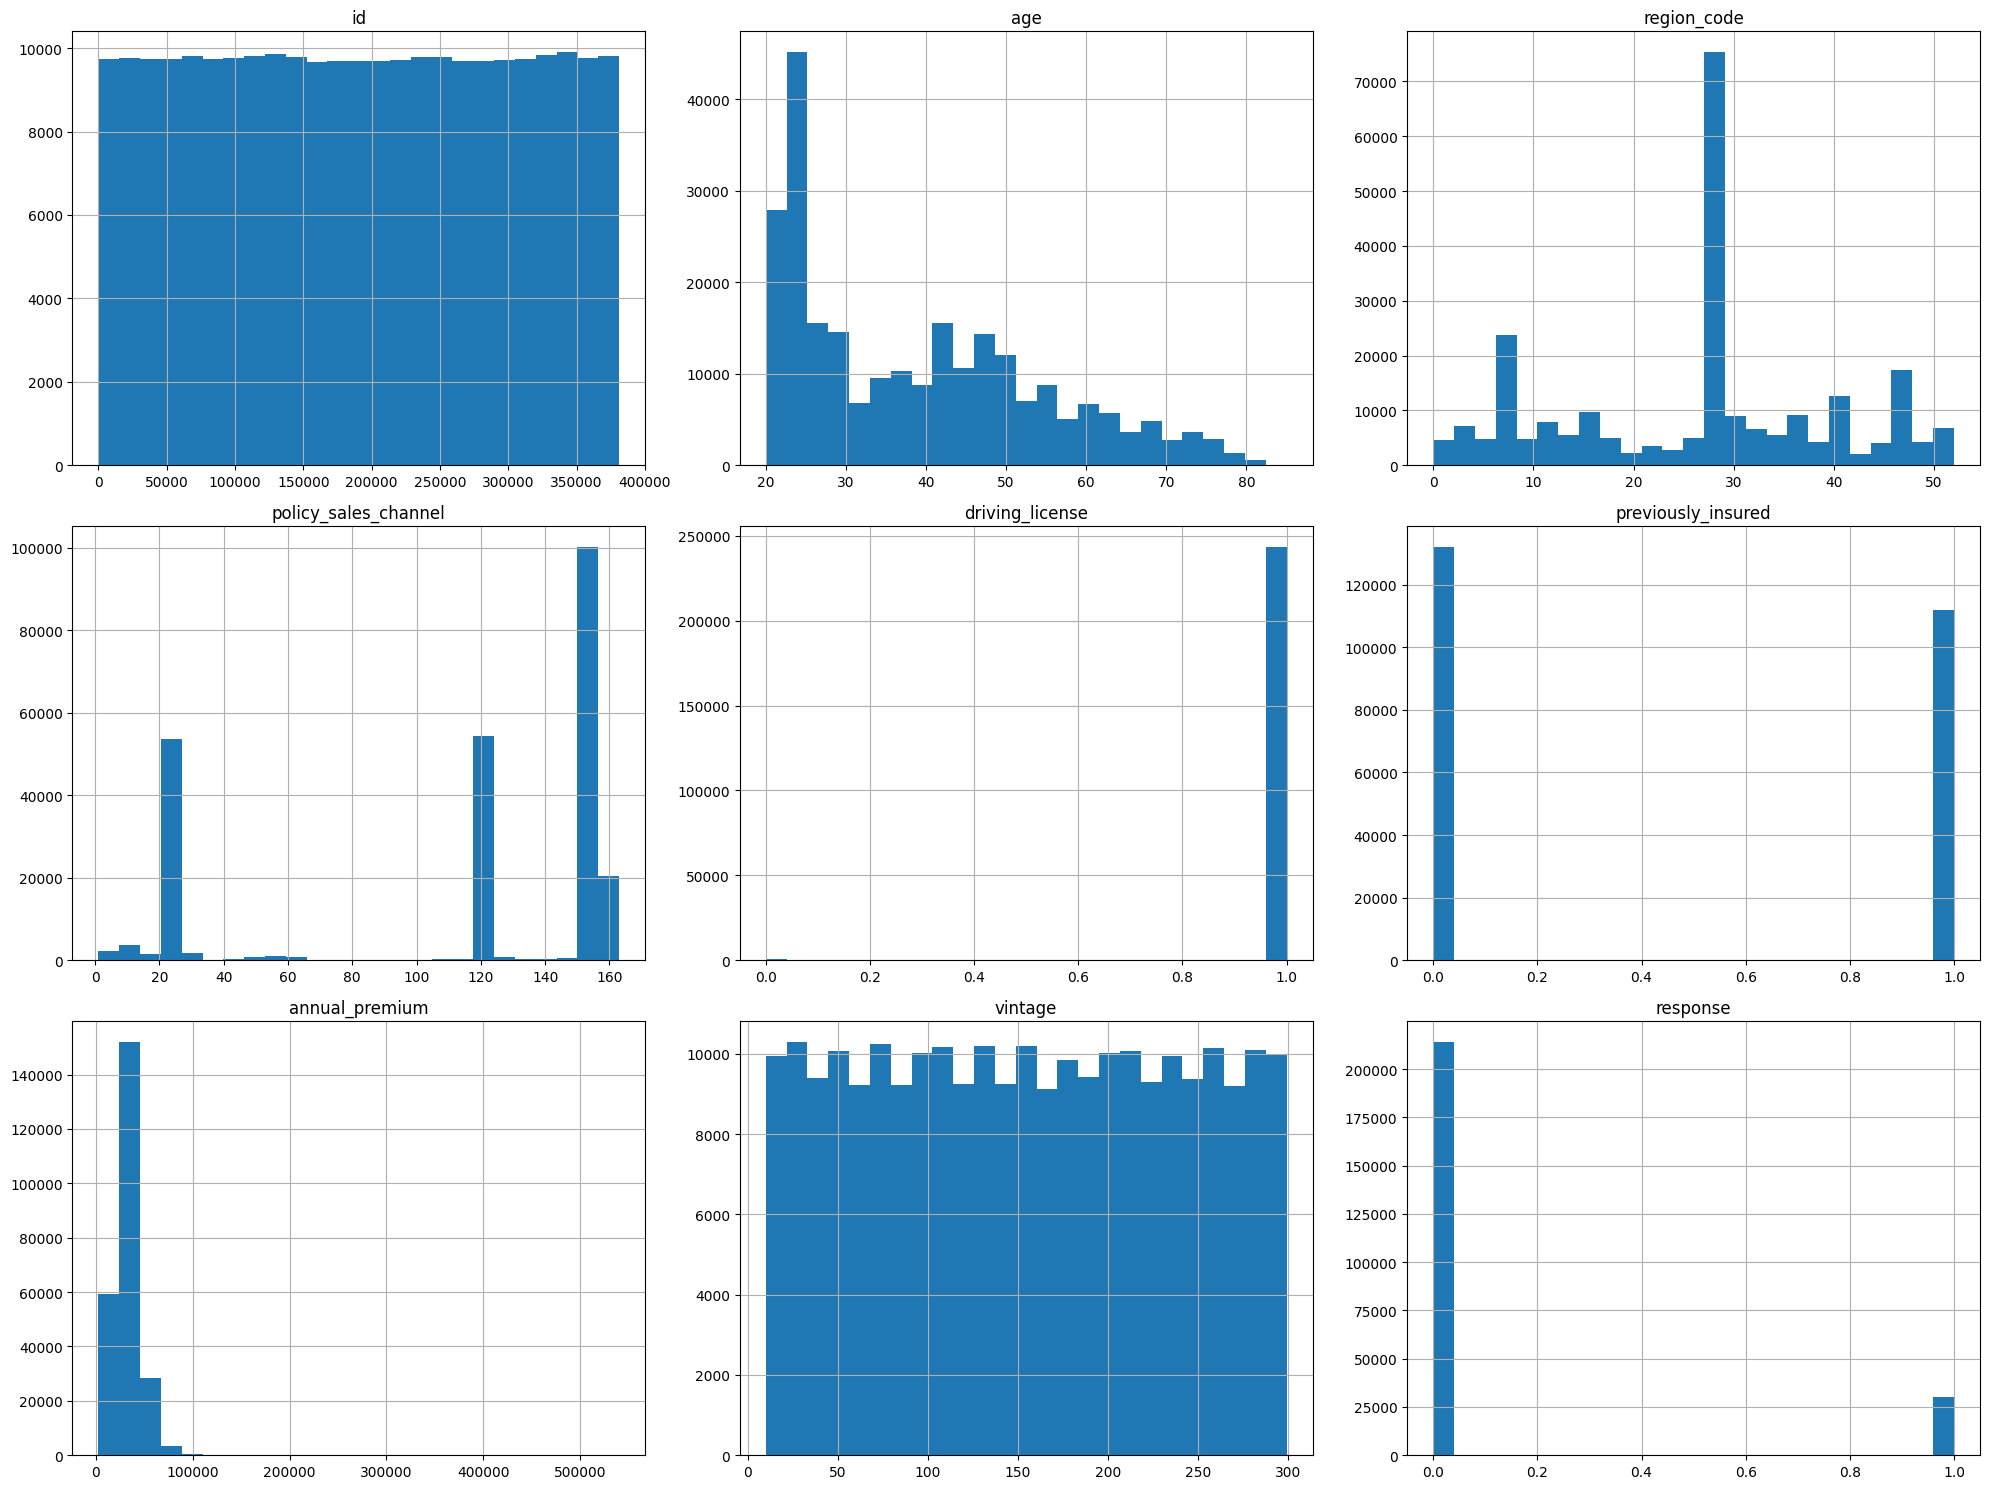

In [27]:
num_attributes = df3.select_dtypes(include = ['int32', 'int64', 'float64'])
num_attributes.hist(bins=25, figsize=(20,15))
plt.tight_layout();

### 3.1.3 Categorical Variable

In [28]:
cat_variables = df3.select_dtypes(exclude = ['int32', 'int64', 'float64'])
cat_variables.head()

,gender,vehicle_age,vehicle_damage,time_of_customer
217927,Female,< 1 Year,Yes,moderate
54207,Male,< 1 Year,No,moderate
18364,Female,1-2 Year,No,expert
195540,Male,1-2 Year,Yes,new
30463,Male,1-2 Year,Yes,old


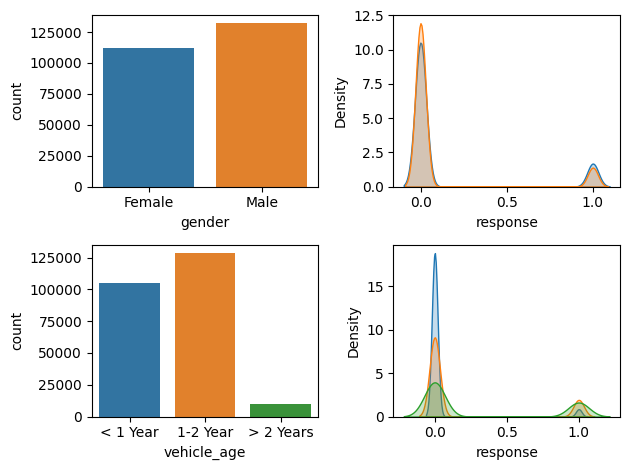

In [30]:
plt.subplot(2, 2, 1)
sns.countplot(data = df3, x='gender')
plt.tight_layout();

plt.subplot(2, 2, 2)
sns.kdeplot(df3[df3['gender'] == 'Male']['response'], label='Male', fill=True)
sns.kdeplot(df3[df3['gender'] == 'Female']['response'], label='Female', fill=True)
plt.tight_layout();

plt.subplot(2,2, 3)
sns.countplot(data=df3, x='vehicle_age')
plt.tight_layout();

plt.subplot(2, 2, 4)
sns.kdeplot(df3[df3['vehicle_age'] == '< 1 Year']['response'], label='< 1 Year', fill=True)
sns.kdeplot(df3[df3['vehicle_age'] == '1-2 Year']['response'], label='1-2 Year', fill=True)
sns.kdeplot(df3[df3['vehicle_age'] == '> 2 Years']['response'], label='> 2 Years', fill=True)
plt.tight_layout();

## 3.2 Análise Bivariada

### H1 - Clientes com mais idade deveriam ter mais propensão a comprar o seguro

**FALSA:** Esse crescimento só existe até a idade estar próximo a média e mediana, após essa idade a própensão tende a cair.

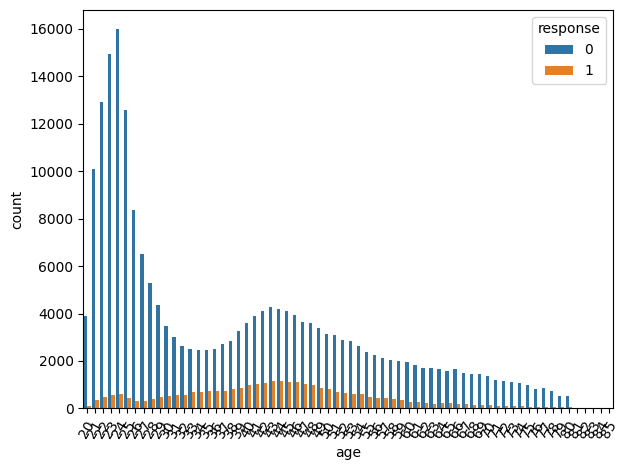

In [32]:
sns.countplot(data= df3, x='age', hue='response')
plt.xticks(rotation=60)
plt.tight_layout();

### H2- Clientes sem habilitação deveriam ter mais propensão a comprar o seguro

**FALSA:** Pessoas sem habilitação tem menos propensão a comprar o seguro

In [33]:
# Percentual de compra dos sem habilitação
aux2 = df3[df3['driving_license'] == 0]
total_sem_licensa =  ((((aux2['response'] == 1).sum()) / (len(aux2))) * 100).round(2)
print(f'Das pessoas sem habilitação {total_sem_licensa}% tem propensão a comprar o seguro.')

# Percentual de compra dos habilitados
aux2_ = df3[df3['driving_license'] == 1]
total_com_licensa =  ((((aux2_['response'] == 1).sum()) / (len(aux2_))) * 100).round(2)
print(f'Das pessoas com habilitação {total_com_licensa}% tem propensão a comprar o seguro.')

Das pessoas sem habilitação 4.91% tem propensão a comprar o seguro.
Das pessoas com habilitação 12.29% tem propensão a comprar o seguro.


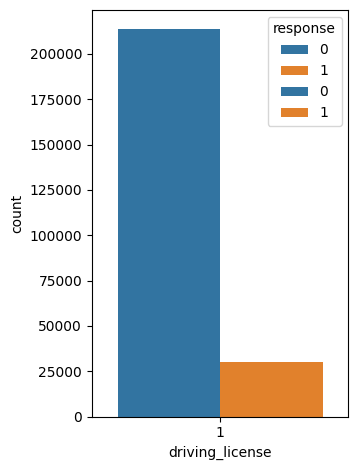

In [34]:
# Sem habilitação
plt.subplot(1, 2, 1)
sns.countplot(data=aux2, x='driving_license', hue='response')

# Habilitados
sns.countplot(data=aux2_, x='driving_license', hue='response')
plt.tight_layout();

### H3- Pessoas que são clientes a mais tempo deveriam ter mais propensão a comprar

**FALSA:** A propensão a compra se mantém a mesma com pessoas que são clientes a mais de 40 dias


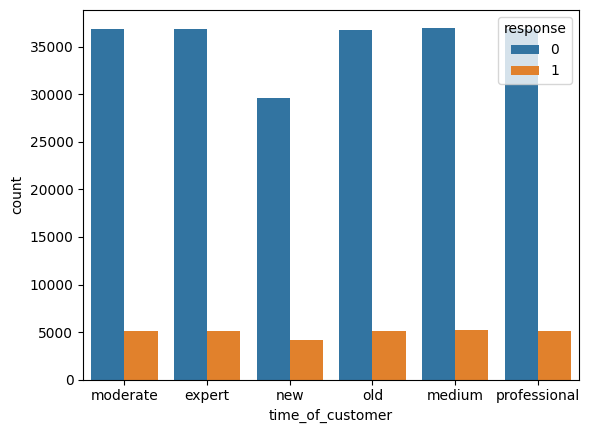

In [35]:
sns.countplot(data=df3, x='time_of_customer', hue='response');

### H4- Clientes do gênero femnino deveriam ter mais propensão a comprar

**FALSA:** Clientes do gênero feninino tem 2,71% menos de propensão a comprar o seguro

In [36]:
female_response = ((((df3['gender'] == 'Female') & (df3['response'] == 1)).sum()) / len(df3['gender']) * 100).round(2)
print(f'Clientes do gênero Female tem {female_response}% de propensão de compra do seguro.')

male_response = ((((df3['gender'] == 'Male') & (df3['response'] == 1)).sum()) / len(df3['gender']) * 100).round(2)
print(f'Clientes do gênero Male tem {male_response}% de propensão de compra do seguro.')

Clientes do gênero Female tem 4.78% de propensão de compra do seguro.
Clientes do gênero Male tem 7.49% de propensão de compra do seguro.


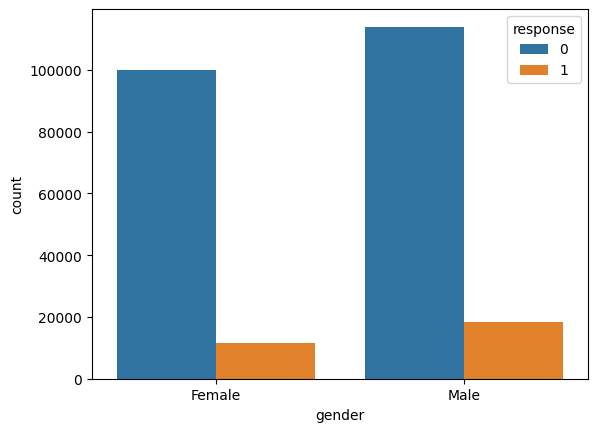

In [37]:
sns.countplot(data=df3, x='gender', hue='response');

### H5- Clientes com prêmio de seguro anual menor deveriam ter mais propensão a comprar

**VERDADEIRA:** Clientes tem mais propensão a comprar quando o prêmio anual é de até 40.000


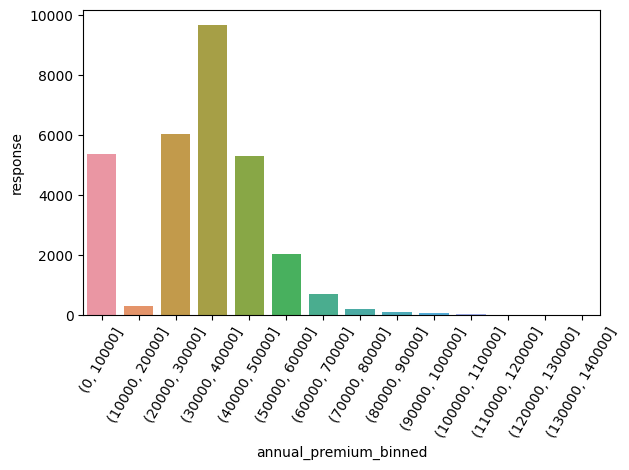

In [38]:
h5 = df3[['annual_premium', 'response']].groupby('annual_premium').sum().reset_index()

bins = list(np.arange(0, 150000, 10000))

h5['annual_premium_binned'] = pd.cut(h5['annual_premium'], bins=bins)
h5_ = h5[['annual_premium_binned', 'response']].groupby('annual_premium_binned').sum().reset_index()
sns.barplot(x='annual_premium_binned', y='response', data=h5_)
plt.xticks(rotation=60)
plt.tight_layout();


### H6- Clientes que já tem seguro deveriam ter menos propensão a comprar

**VERDADEIRA:** Clientes com seguro automotivo possuem baixa propensão a comprar o produto

In [39]:
insurance = (((df3['previously_insured'] == 1) & (df3['response'] == 1)).sum() / (len(df3['previously_insured'] == 1)) *100).round(2)
less_insurance = (((df3['previously_insured'] == 0) & (df3['response'] == 1)).sum() / (len(df3['previously_insured'] == 0))* 100).round(2)
print(f'Clientes que já possuem seguro automotivo tem {insurance}% de propensão de compra')
print(f'Clientes que não possuem seguro automotivo tem {less_insurance}% de propensão de compra')

Clientes que já possuem seguro automotivo tem 0.04% de propensão de compra
Clientes que não possuem seguro automotivo tem 12.23% de propensão de compra


<Axes: xlabel='previously_insured', ylabel='count'>

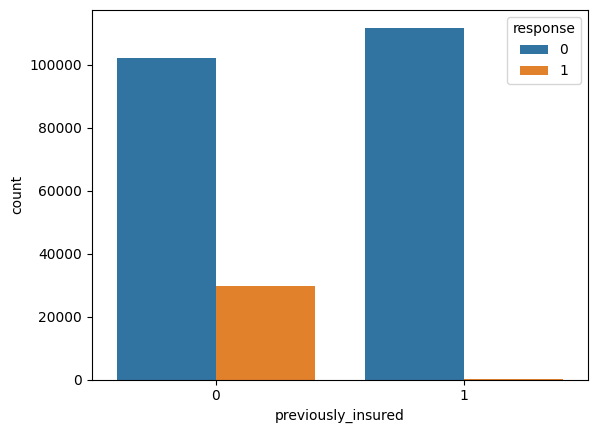

In [40]:
sns.countplot(x='previously_insured', hue='response', data=df3)

### H7- Clientes com veículos mais novos deveriam ter mais propensão a comprar

**FALSA:** A propensão a compra é maior em clientes com veículos entre 1 e 2 anos.

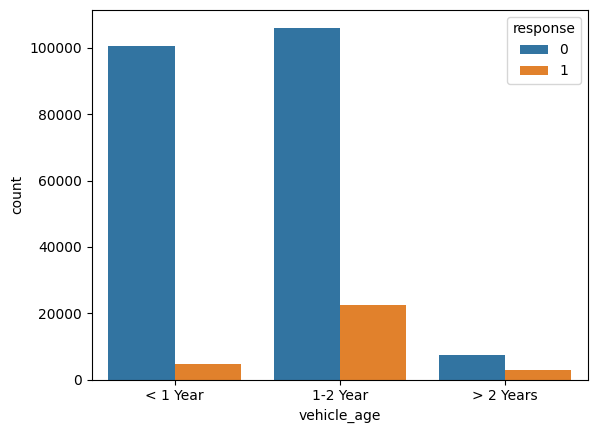

In [41]:
sns.countplot(x='vehicle_age', hue='response', data=df3);

### H8- Clientes com veículos que já sofreram acidentes deveriam ter mais propensão a comprar

**VERDADEIRA:** Clientes que já sofreram danos veículares tem mais propensão a comprar o seguro


In [42]:
yes_damage = ((((df3['vehicle_damage'] == 1) & (df3['response'] == 1)).sum()) / (len(df3['vehicle_damage'] == 1)) * 100).round(2)
not_damage = ((((df3['vehicle_damage'] == 0) & (df3['response'] == 1)).sum()) / (len(df3['vehicle_damage'] == 0)) * 100).round(2)
print(f'Clientes com veículos que já sofreram danos veículares no passado tem {yes_damage}% de propensão de compra')
print(f'Clientes com veículos que não sofreram danos veículares no passado tem {not_damage}% de propensão de compra')

Clientes com veículos que já sofreram danos veículares no passado tem 0.0% de propensão de compra
Clientes com veículos que não sofreram danos veículares no passado tem 0.0% de propensão de compra


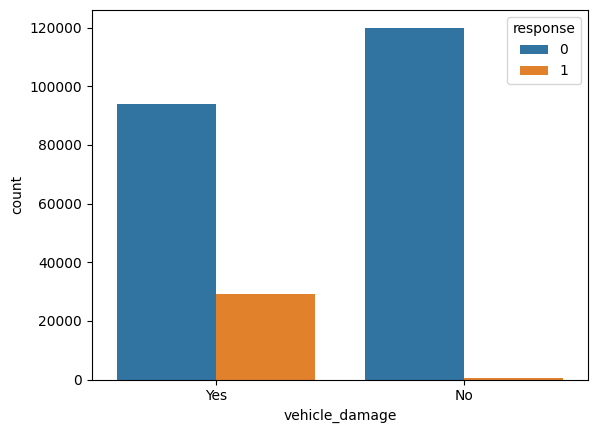

In [43]:
sns.countplot(x='vehicle_damage', hue='response', data=df3);

## 3.3 Análise Multivariada

### 3.3.1 Numerical Variable

In [44]:
#correlação.hitmap

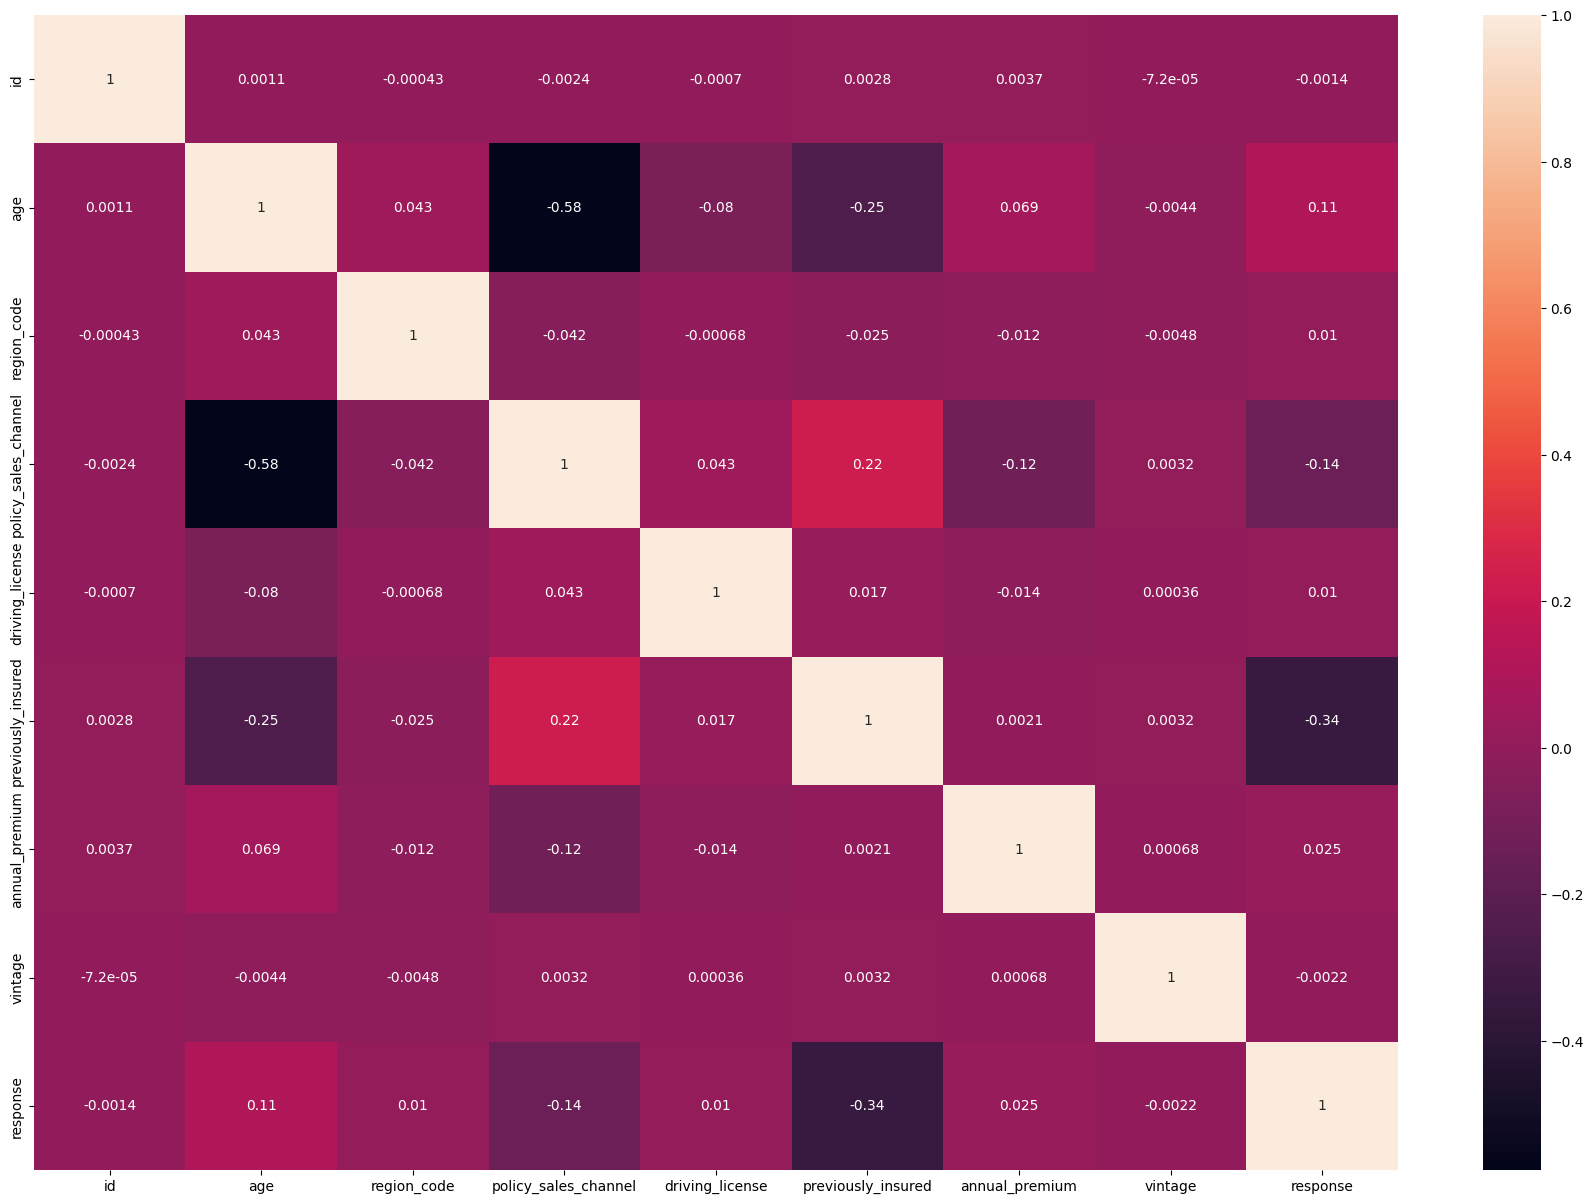

In [47]:
correlation = num_attributes.corr(method='pearson')

fig, ax=plt.subplots(figsize=(22,15))

sns.heatmap(correlation, annot=True);


### 3.3.2 Categorical Variable

<Axes: >

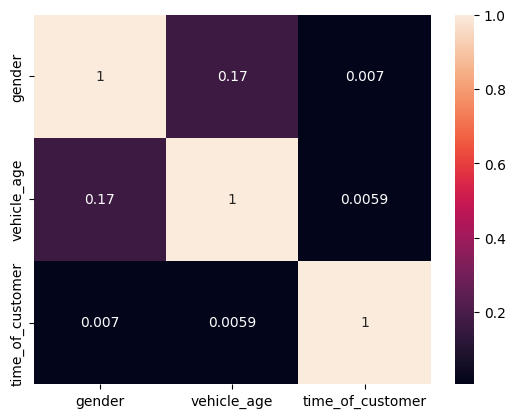

In [49]:
#V de cramer

cat = df3.select_dtypes(include=['object'])
cat_list = [ 'gender', 'vehicle_age', 'time_of_customer']
cat_dic = {}

for c1 in cat_list:
    for c2 in cat_list:
        v = cramer_v(cat[c1], cat[c2])
        
        if cat_list.index(c2) == 0:
            cat_dic[c1] = []
            cat_dic[c1].append(v)

        else:
            cat_dic[c1].append(v)


cramer_v_table = pd.DataFrame(cat_dic)
cramer_v_table.set_index(cramer_v_table.columns, inplace=True)


sns.heatmap(cramer_v_table, annot=True)

# 4.0 Data Preparation

In [230]:
df4 = df3.copy()

## 4.1 Rescaling

In [231]:
# age
mms_age = MinMaxScaler()

df4['age'] = mms_age.fit_transform(df4[['age']].values)


# vintage
mms_vintage = MinMaxScaler()
df4['vintage'] = mms_vintage.fit_transform(df4[['vintage']].values)


## 4.2 Encoding

In [232]:
# gender - LabelEncoding
df4['gender'] = df4['gender'].apply(lambda x: 0 if x == 'Female' else 1)

# region_code - target
target_region_code = df4.groupby('region_code')['response'].mean()
df4.loc[:, 'region_code'] = df4['region_code'].map(target_region_code)

#te = TargetEncoder()
#df4['region_code'] = te.fit_transform(df4['region_code'], df4['response'])

# vehicle_age - Order Encoding
le = LabelEncoder()
df4['vehicle_age'] = le.fit_transform(df4['vehicle_age'])

# time_of_customer - Label
df4['time_of_customer'] = le.fit_transform(df4['time_of_customer'])

# vehicle_damage - Label
df4['vehicle_damage'] = le.fit_transform(df4['vehicle_damage'])


# policy_sales_channel - Frequency
fe_policy_channel = df4.groupby('policy_sales_channel').size() / len(df4)
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map(fe_policy_channel)



## 4.3 Standarization

In [233]:
# annual_premium

ss = StandardScaler()

df4['annual_premium'] = ss.fit_transform(df4[['annual_premium']].values)

## 4.3 Validation Preparation

In [234]:
#create time_of_customer in X_val
X_val['time_of_customer'] = X_val['vintage'].apply(lambda x: 'new' if x < 50 else 'moderate' if x < 100 else 'medium' if x < 150 else 'professional' if x < 200 else 'expert' if x < 250 else 'old')

In [235]:
# age
X_val['age'] = mms_age.fit_transform(X_val[['age']].values)


# vintage
X_val['vintage'] = mms_vintage.fit_transform(X_val[['vintage']].values)


#gender val
X_val['gender'] = X_val['gender'].apply(lambda x: 0 if x == 'Female' else 1)

#region_code
X_val.loc[:, 'region_code'] = X_val['region_code'].map(target_region_code)

# vehicle_age - Order Encoding
X_val['vehicle_age'] = le.fit_transform(X_val['vehicle_age'])

# time_of_customer - Label
X_val['time_of_customer'] = le.fit_transform(X_val['time_of_customer'])

# vehicle_damage - Label
X_val['vehicle_damage'] = le.fit_transform(X_val['vehicle_damage'])

# policy_sales_channel - Frequency
X_val.loc[:, 'policy_sales_channel'] = X_val['policy_sales_channel'].map(fe_policy_channel)

# annual_premium
X_val['annual_premium'] = ss.fit_transform(X_val[['annual_premium']].values)

#fillna
X_val = X_val.fillna(0)

# 5.0 Feature Selection

In [236]:
df5 = df4.copy()

X_train = df5.drop(columns=['response', 'id'])
y_train = df5['response'].copy()

## 5.1 Feature Importance

In [175]:
#model definition
rf_importance = RandomForestClassifier(n_estimators=50, max_depth=50, min_samples_split=2, min_samples_leaf=1, random_state=42)

rf_importance.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=50, random_state=42)

Feature Ranking:
                feature  importance
0               vintage    0.237669
0        annual_premium    0.233535
0                   age    0.166262
0           region_code    0.102202
0  policy_sales_channel    0.074063
0        vehicle_damage    0.068785
0    previously_insured    0.058537
0      time_of_customer    0.032640
0                gender    0.014209
0           vehicle_age    0.011523
0       driving_license    0.000576


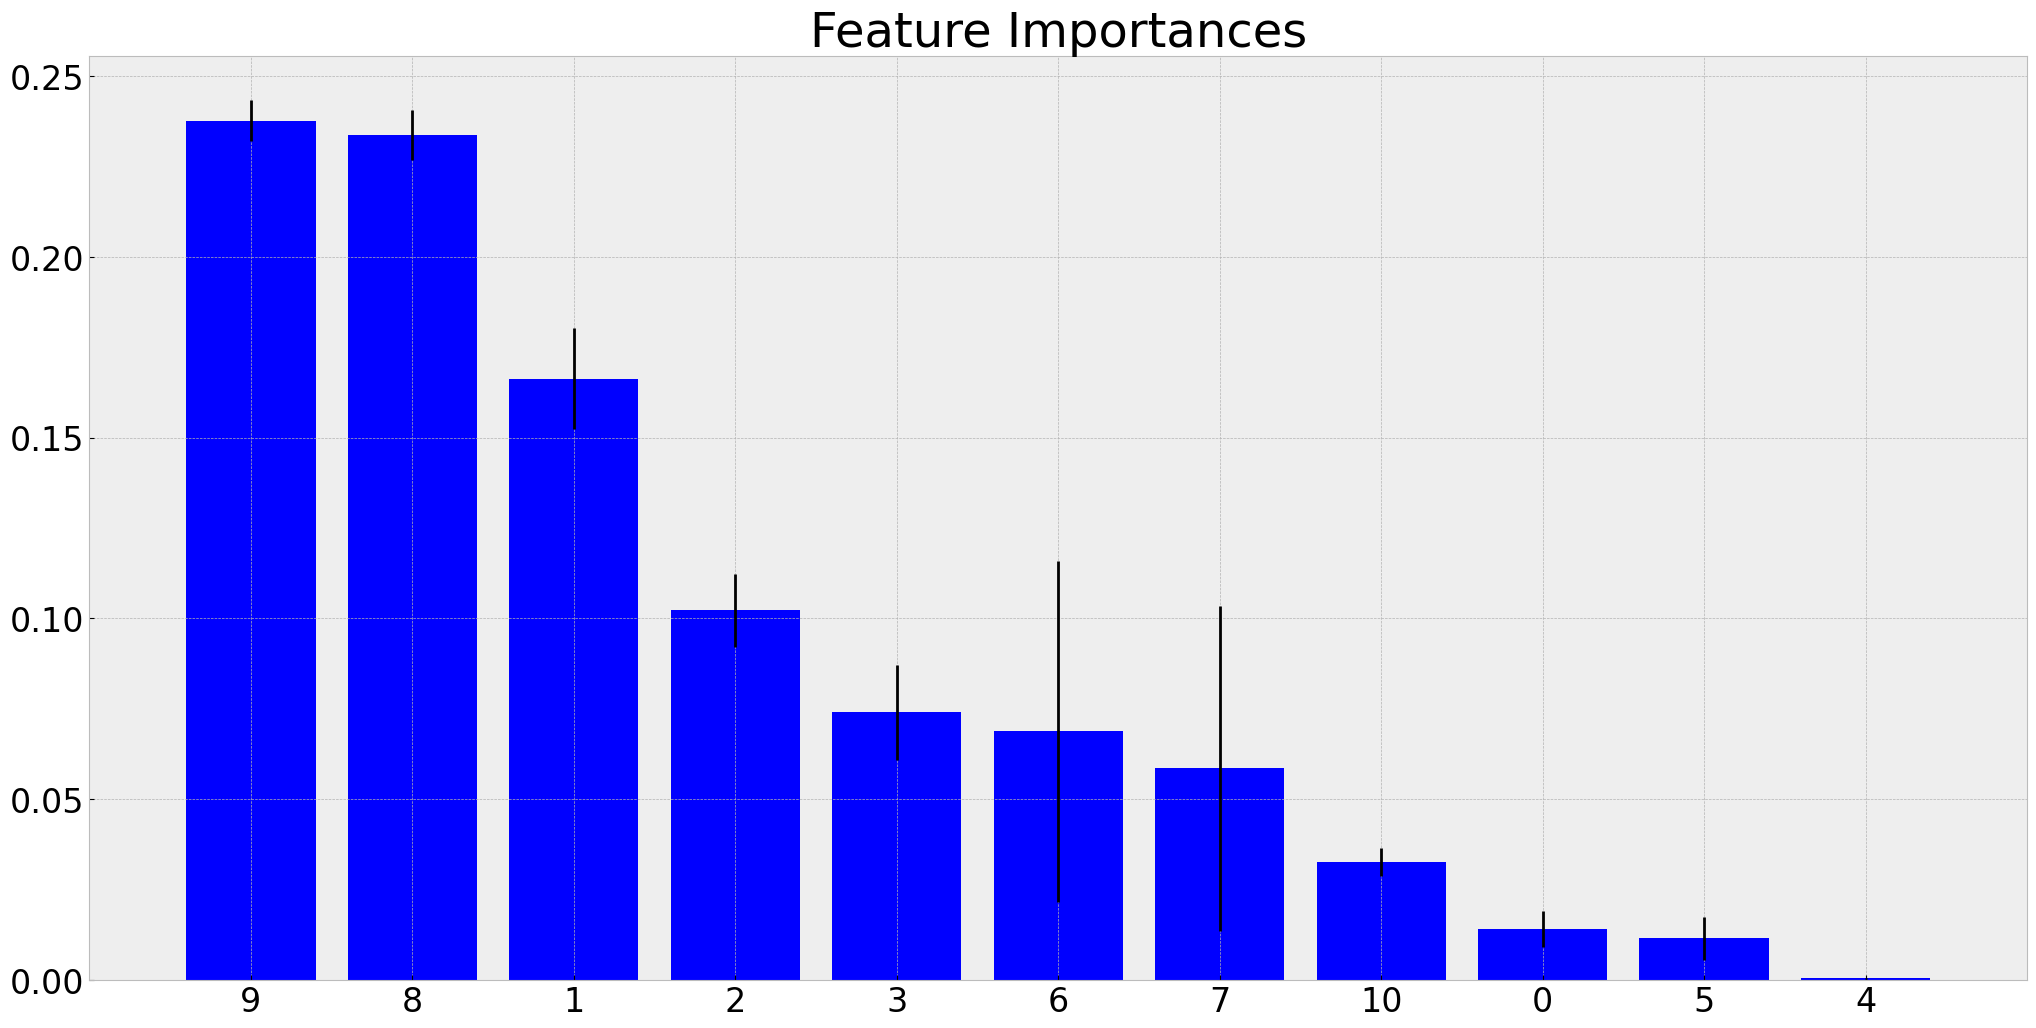

In [182]:
importance = rf_importance.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_importance.estimators_], axis=0)
indices = np.argsort(importance)[::-1]

# Print the feature ranking
print('Feature Ranking:')
df_ = pd.DataFrame()
for i, j in zip( X_train, rf_importance.feature_importances_ ):
    aux = pd.DataFrame( { 'feature': i, 'importance': j}, index=[0])
    df_ = pd.concat( [df_, aux], axis=0)
     
print(df_.sort_values('importance', ascending=False ) )

#plot the impurity-based feature importance of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importance[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim( [ -1, X_train.shape[1]])
plt.show()


## 5.2 Manual Feature Selection

In [237]:
cols_selected = ['age', 'region_code', 'policy_sales_channel', 'vehicle_damage', 'previously_insured', 'annual_premium', 'vintage']

In [238]:
X_validation = X_val
X_train = X_train[cols_selected]
X_test = X_test[cols_selected]
X_val = X_val[cols_selected]

In [146]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(243909, 7)
(76222, 7)
(60978, 7)


# 6.0 Machine Learning

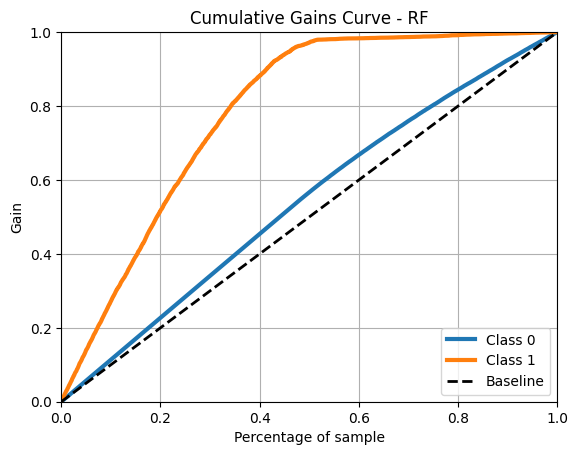

In [295]:
#model
rf_model = RandomForestClassifier(n_estimators=50, 
                                  max_depth=50, 
                                  random_state=42, 
                                  class_weight='balanced')

#training
rf_model.fit(X_train, y_train)

#prediction
yhat_rf = rf_model.predict_proba(X_val)
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, 
                                   title='Cumulative Gains Curve - RF')
plt.show();

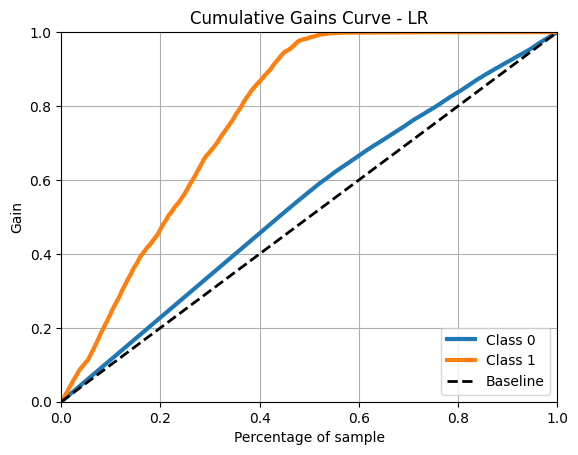

In [301]:
#model
lr_model = LogisticRegression(solver='saga', class_weight='balanced')

#training
lr_model.fit(X_train, y_train)

#prediction
yhat_lr = lr_model.predict_proba(X_val)
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, 
                                   title='Cumulative Gains Curve - LR')
plt.show();

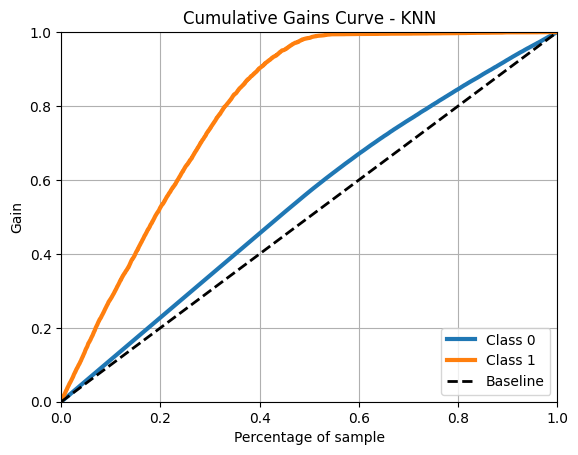

In [278]:
#model
knn_model = KNeighborsClassifier(n_neighbors=50)

#training
knn_model.fit(X_train, y_train)

#prediction
yhat_knn = knn_model.predict_proba(X_val)
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, 
                                   title='Cumulative Gains Curve - KNN')
plt.show();

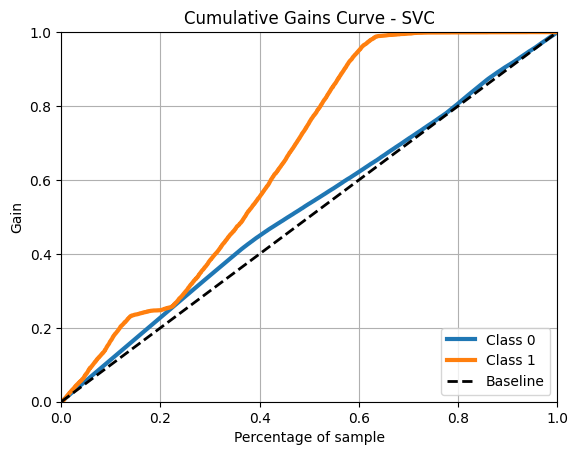

In [184]:
#model
svc_model = SVC(gamma='auto', max_iter=12, probability=True)

#training
svc_model.fit(X_train, y_train)

#prediction
yhat_svc = svc_model.predict_proba(X_val)
skplt.metrics.plot_cumulative_gain(y_val, yhat_svc, 
                                   title='Cumulative Gains Curve - SVC')
plt.show();

# 7.0 Model Performance

In [240]:
df7 = X_validation.copy()

In [296]:
# Create column response
df7['response'] = y_val.copy()

#create column score
df7['score'] = yhat_rf[:,1].tolist()

# sort clientes by propensity score
df7 = df7.sort_values( 'score', ascending=False)


In [297]:
def precision_at_k (data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    #create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']
    

In [299]:
precision_at_k(df7, k=4)

0.0

In [ ]:
df7

In [300]:
df7[['id', 'score', 'response']].reset_index(drop=True).head(20)

,id,score,response
0,319102,0.979232,0
1,328746,0.940000,0
2,99423,0.940000,0
3,2310,0.920000,0
4,215860,0.920000,0
5,293463,0.920000,0
6,15091,0.920000,0
7,356644,0.919656,0
8,6966,0.900000,0
9,229115,0.900000,0


In [285]:
yhat_knn

array([[0.9 , 0.1 ],
       [0.64, 0.36],
       [0.5 , 0.5 ],
       ...,
       [0.74, 0.26],
       [0.68, 0.32],
       [1.  , 0.  ]])